In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime


In [19]:
file_path = '/content/clickstream_data.csv'  # Change this path if needed
df = pd.read_csv(file_path, sep=';')



In [20]:
display(df.head())
print(df.info())
print(df.describe())

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   year                     165474 non-null  int64 
 1   month                    165474 non-null  int64 
 2   day                      165474 non-null  int64 
 3   order                    165474 non-null  int64 
 4   country                  165474 non-null  int64 
 5   session ID               165474 non-null  int64 
 6   page 1 (main category)   165474 non-null  int64 
 7   page 2 (clothing model)  165474 non-null  object
 8   colour                   165474 non-null  int64 
 9   location                 165474 non-null  int64 
 10  model photography        165474 non-null  int64 
 11  price                    165474 non-null  int64 
 12  price 2                  165474 non-null  int64 
 13  page                     165474 non-null  int64 
dtypes: int64(13), object

In [30]:
# Check for missing values
print(df.isnull().sum())

# Display basic statistics
print(df.describe())
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Detect outliers using IQR method
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]

print("Outliers removed based on price column.")


# Drop rows with missing values (if necessary)
df.dropna(inplace=True)


year                       0
month                      0
day                        0
order                      0
country                    0
session ID                 0
page 1 (main category)     0
page 2 (clothing model)    0
colour                     0
location                   0
model photography          0
price                      0
price 2                    0
page                       0
date                       0
day_of_week                0
dtype: int64
           year          month            day          order        country  \
count  165474.0  165474.000000  165474.000000  165474.000000  165474.000000   
mean     2008.0       5.585887      14.524554       9.817476      26.952621   
min      2008.0       4.000000       1.000000       1.000000       1.000000   
25%      2008.0       4.000000       7.000000       2.000000      29.000000   
50%      2008.0       5.000000      14.000000       6.000000      29.000000   
75%      2008.0       7.000000      22.000000    

<ipython-input-30-1f65427c3b8b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [24]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Extract the actual day name (Monday, Tuesday, etc.)
df['day_of_week'] = df['date'].dt.day_name()

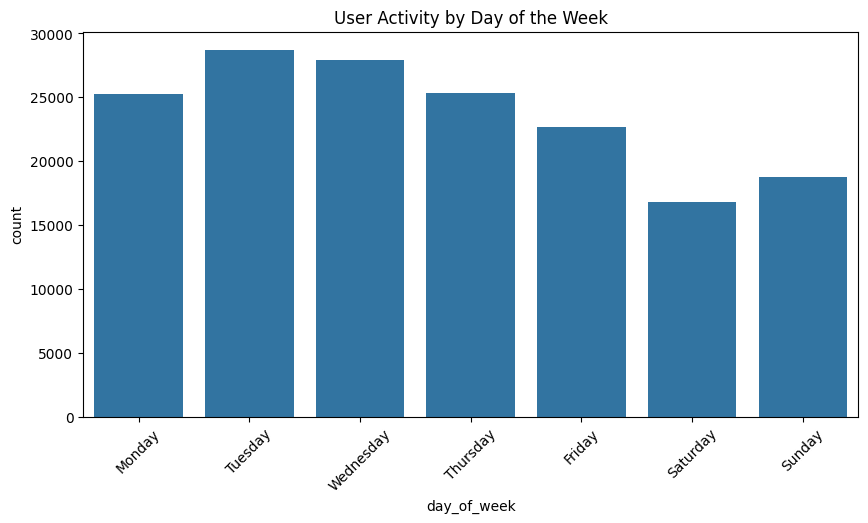

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(x='day_of_week', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('User Activity by Day of the Week')
plt.xticks(rotation=45)
plt.show()

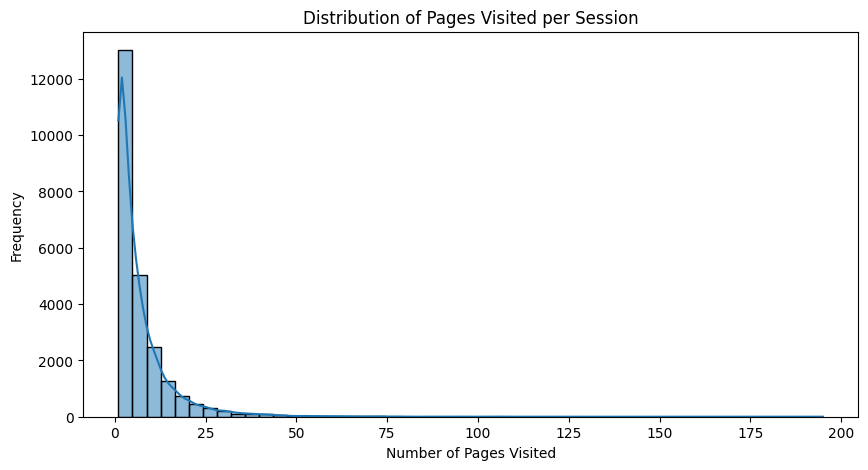

In [27]:
# Count number of pages visited per session
session_activity = df.groupby('session ID')['page'].count().reset_index()
session_activity.columns = ['session ID', 'pages_visited']

# Plot session activity
plt.figure(figsize=(10, 5))
sns.histplot(session_activity['pages_visited'], bins=50, kde=True)
plt.title('Distribution of Pages Visited per Session')
plt.xlabel('Number of Pages Visited')
plt.ylabel('Frequency')
plt.show()


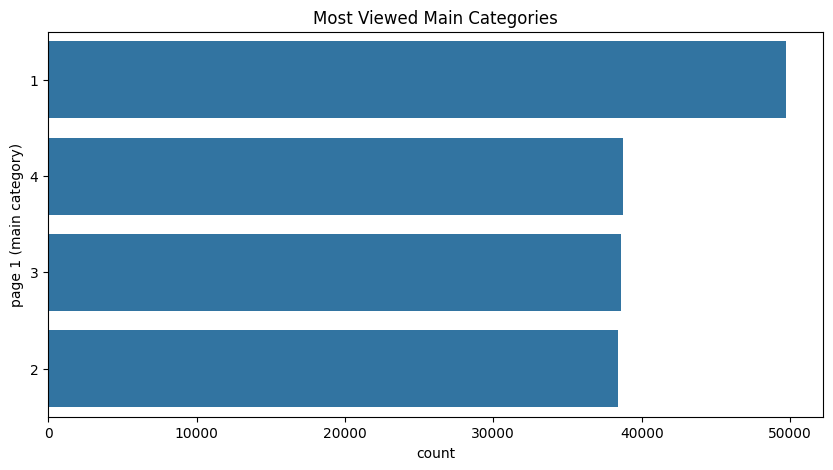

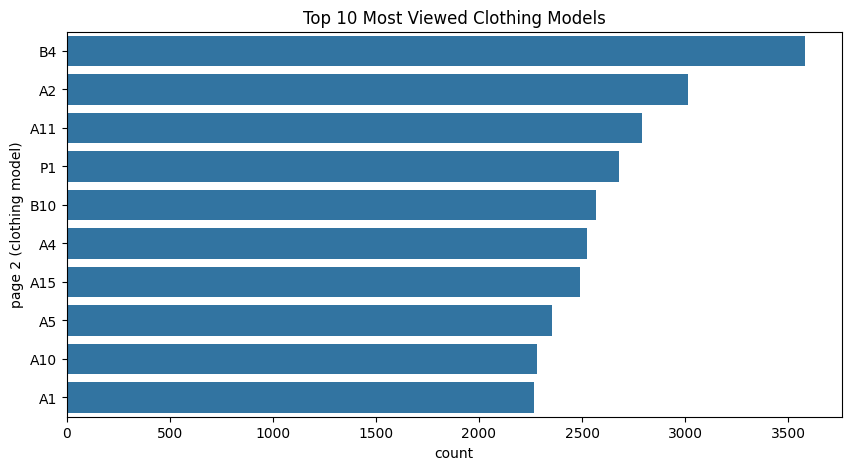

In [28]:
# Most popular main categories
plt.figure(figsize=(10, 5))
sns.countplot(y=df['page 1 (main category)'], order=df['page 1 (main category)'].value_counts().index)
plt.title('Most Viewed Main Categories')
plt.show()

# Most popular clothing models
plt.figure(figsize=(10, 5))
sns.countplot(y=df['page 2 (clothing model)'], order=df['page 2 (clothing model)'].value_counts().index[:10])
plt.title('Top 10 Most Viewed Clothing Models')
plt.show()


In [31]:
# Define a bounce session (only 1 page viewed)
df['bounced'] = df.groupby('session ID')['page'].transform('count') == 1

# Calculate bounce rate
bounce_rate = df['bounced'].mean() * 100
print(f"Bounce Rate: {bounce_rate:.2f}%")

# Time spent analysis
if 'time_spent' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df['time_spent'], bins=30, kde=True)
    plt.title('Distribution of Time Spent on Website')
    plt.xlabel('Time Spent (seconds)')
    plt.ylabel('Frequency')
    plt.show()


Bounce Rate: 3.09%


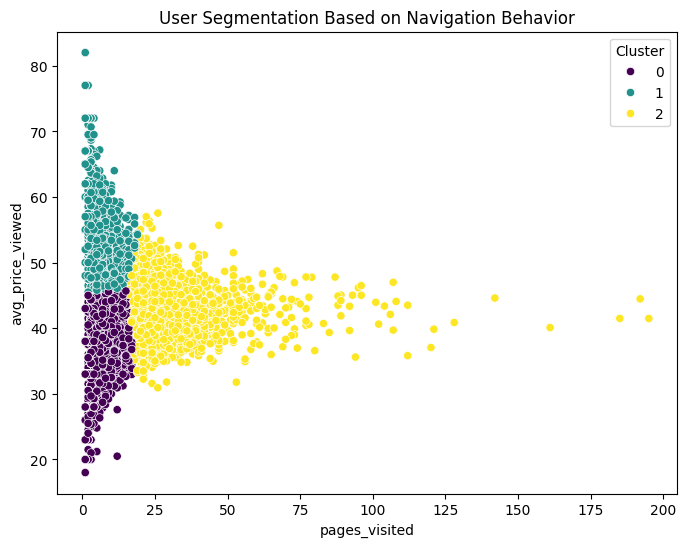

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
clustering_df = df.groupby('session ID').agg({'page': 'count', 'price': 'mean'}).reset_index()
clustering_df.columns = ['session ID', 'pages_visited', 'avg_price_viewed']

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_df[['pages_visited', 'avg_price_viewed']])

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_df['Cluster'] = kmeans.fit_predict(scaled_data)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=clustering_df, x='pages_visited', y='avg_price_viewed', hue='Cluster', palette='viridis')
plt.title('User Segmentation Based on Navigation Behavior')
plt.show()
